In [5]:
# 1. LECTURA DEL SET DE DATOS
# ===============================================
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

datos = pd.read_csv("./datasets/creditcard.csv")
print(datos.head())

nr_clases = datos['Class'].value_counts(sort=True)
print(nr_clases)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

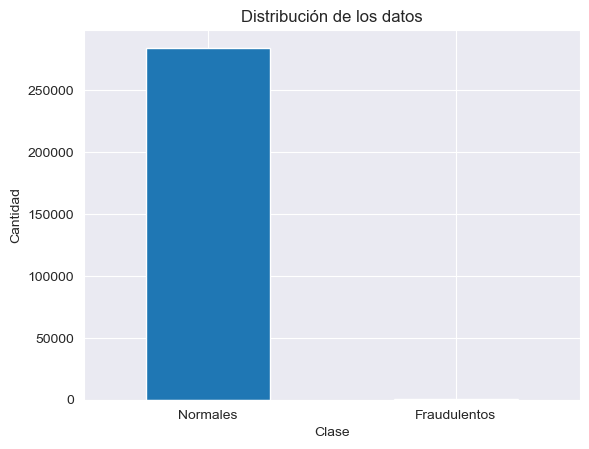

In [6]:
# 2. ANÁLISIS EXPLORATORIO DE LOS DATOS
# ===============================================

# Cantidad de registros normales vs. fraudulentos
nr_clases.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Fraudulentos'])
plt.title("Distribución de los datos")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

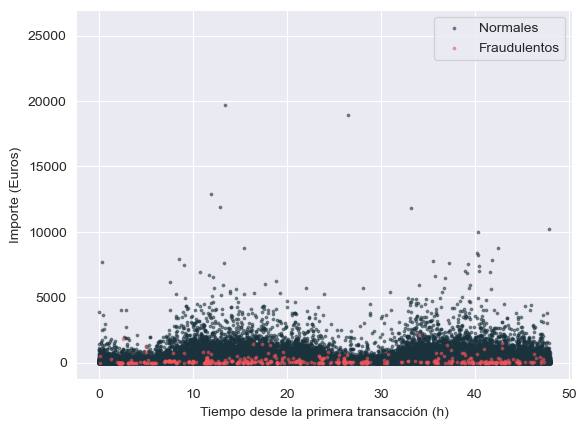

In [7]:
# Importe de las transacciones vs. tiempo
normales = datos[datos.Class==0]
fraudulentos = datos[datos.Class==1]
plt.scatter(normales.Time/3600, normales.Amount, 
	alpha = 0.5, c='#19323C', label='Normales', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, 
	alpha = 0.5, c='#F2545B', label='Fraudulentos', s=3)
plt.xlabel('Tiempo desde la primera transacción (h)')
plt.ylabel('Importe (Euros)')
plt.legend(loc='upper right')
plt.show()

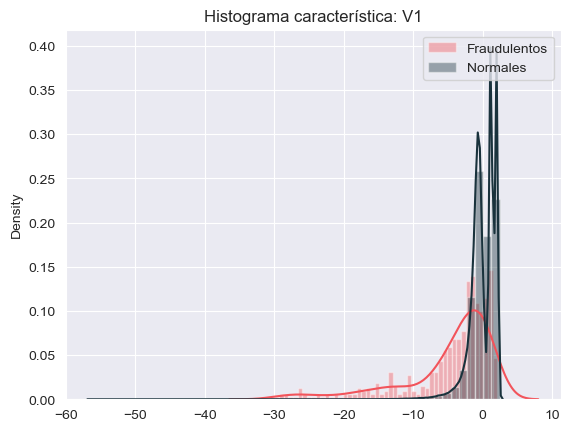

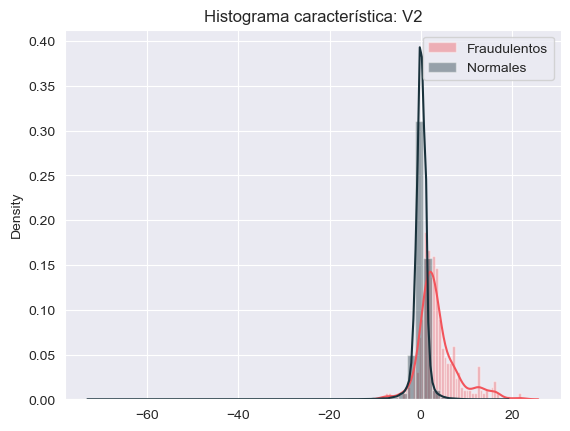

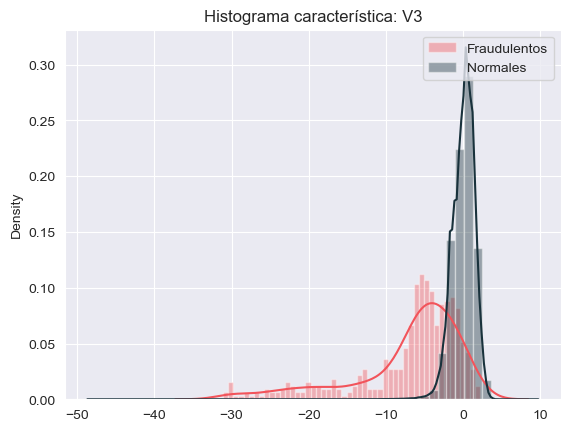

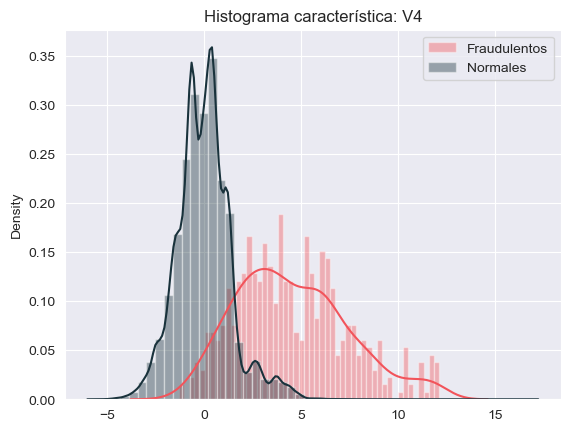

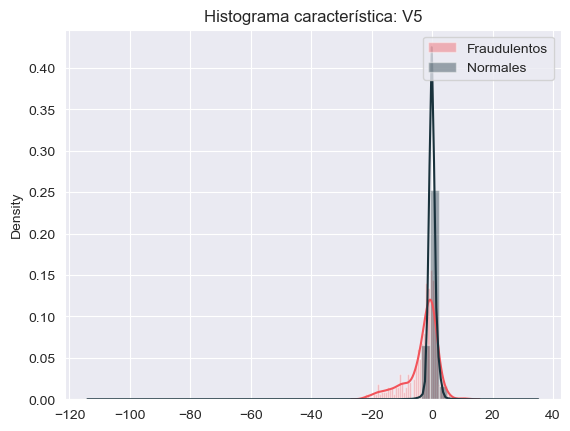

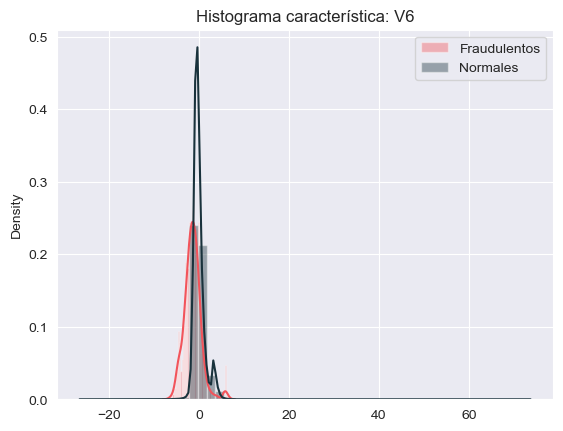

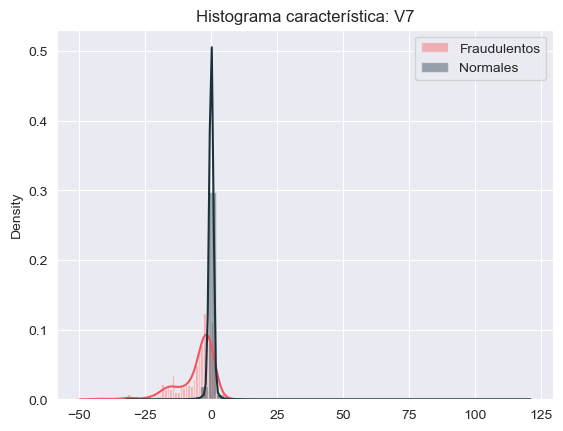

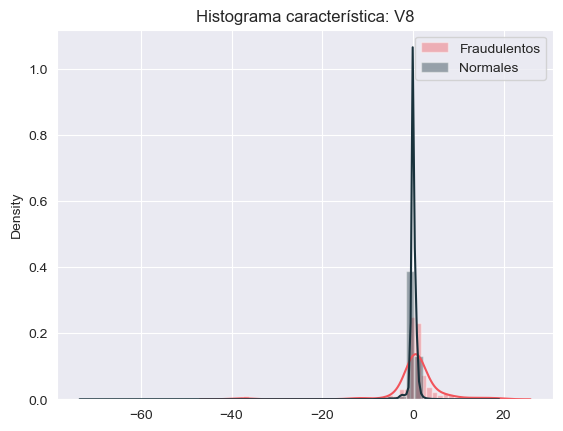

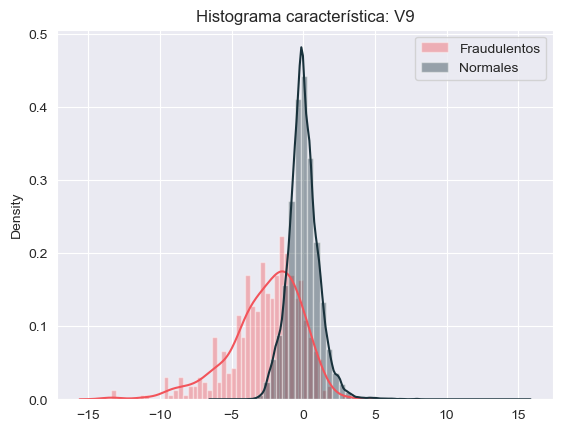

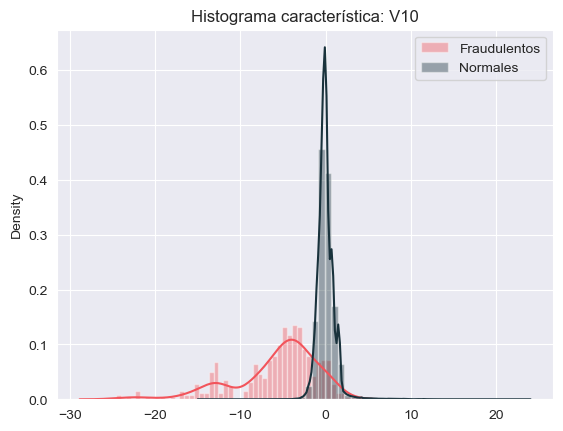

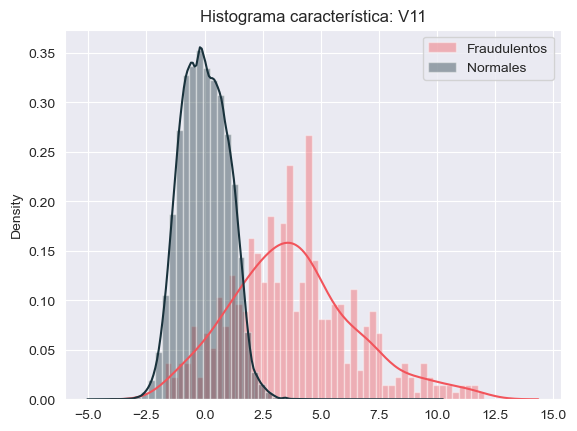

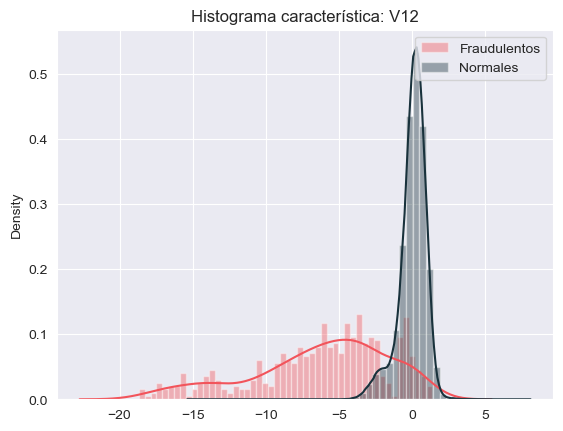

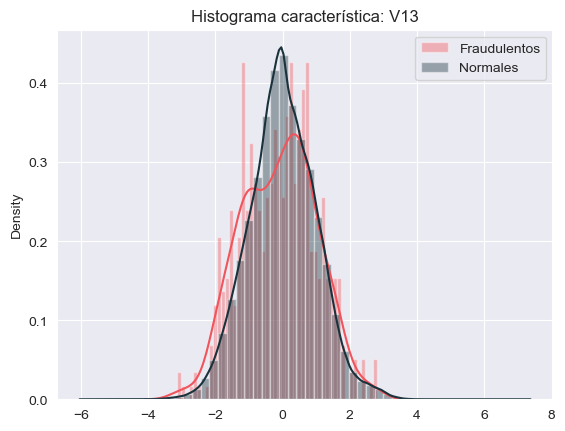

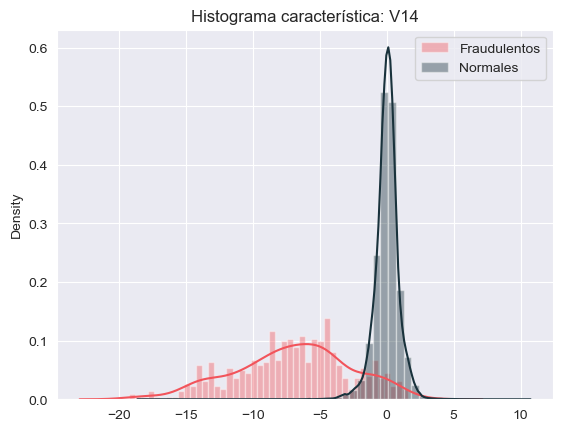

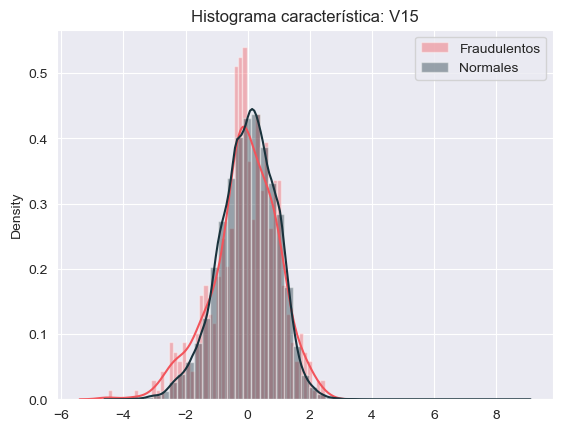

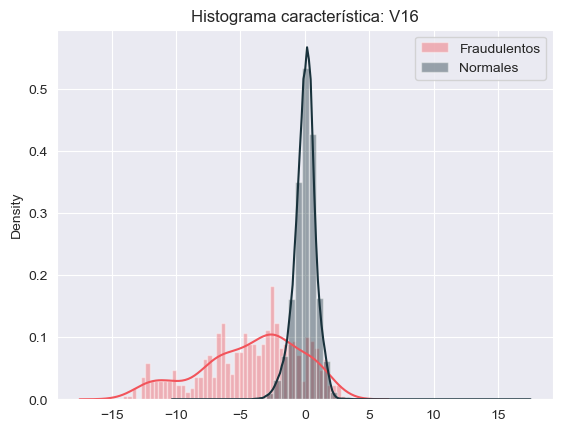

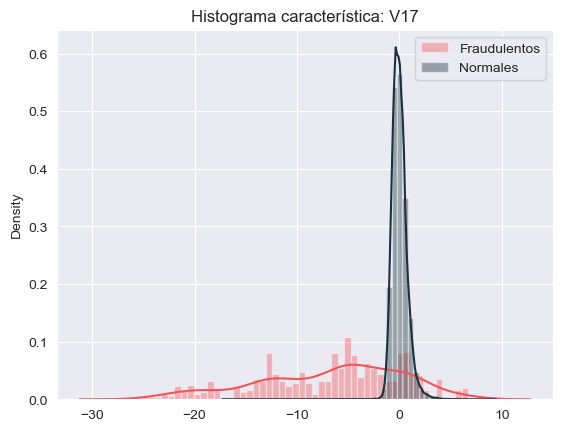

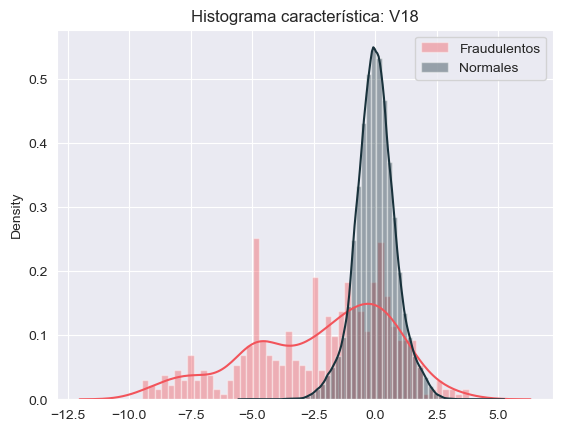

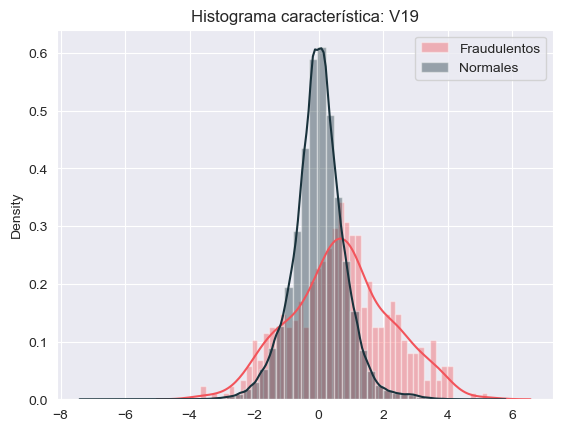

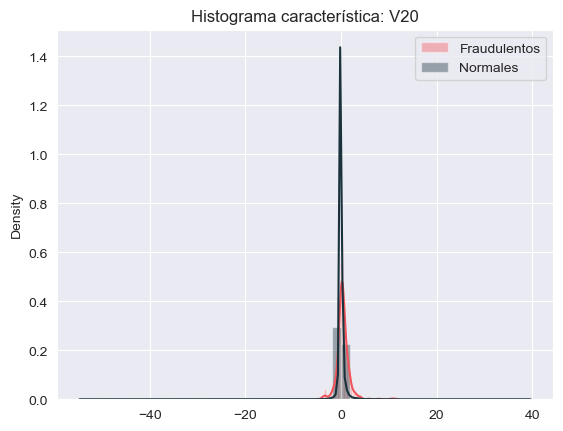

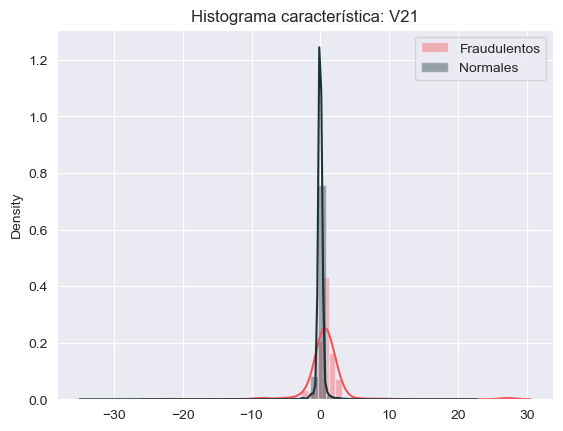

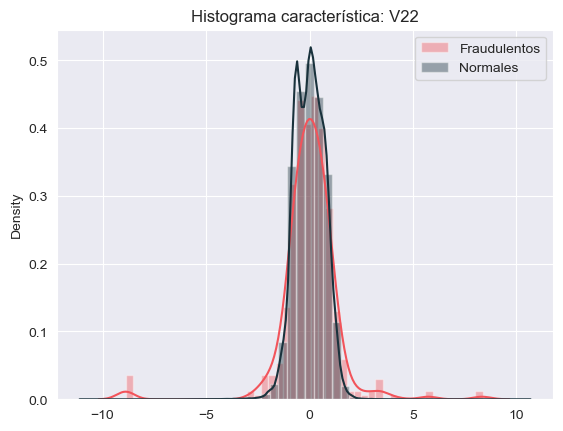

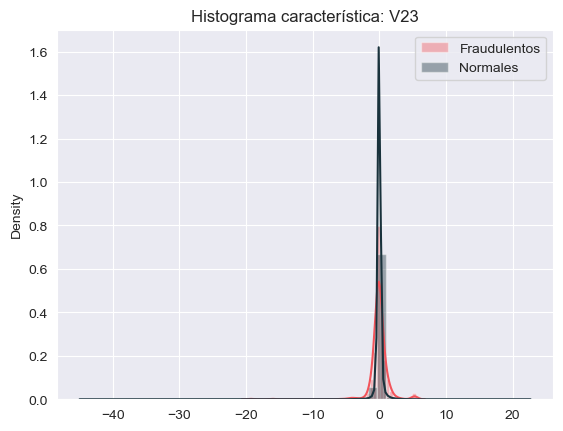

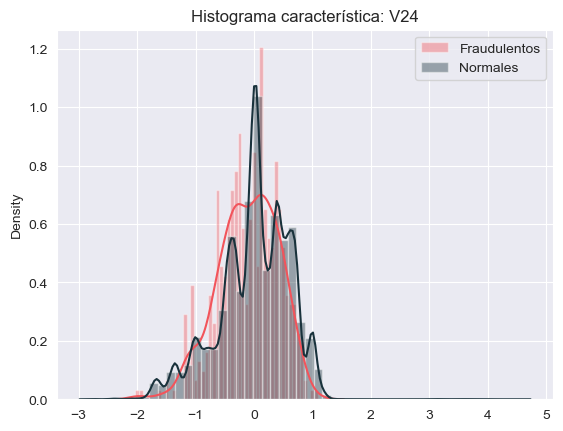

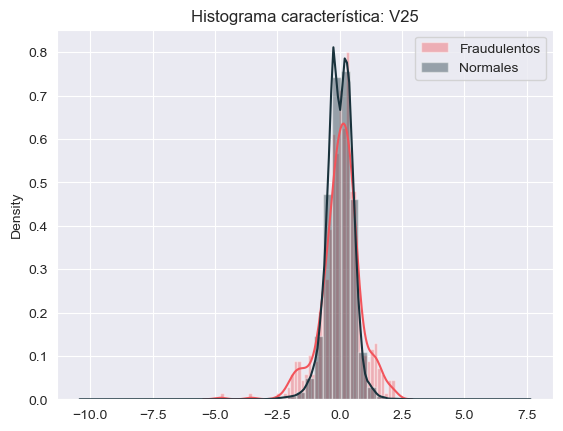

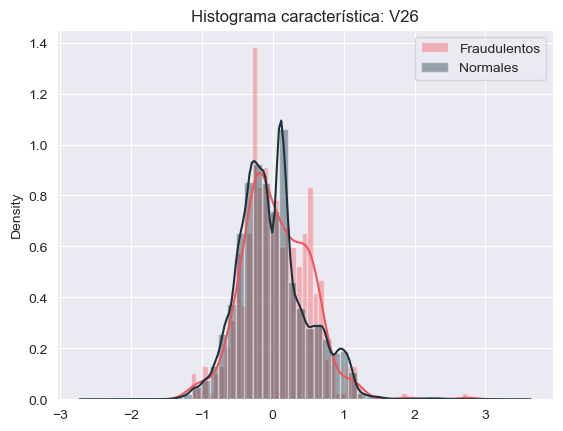

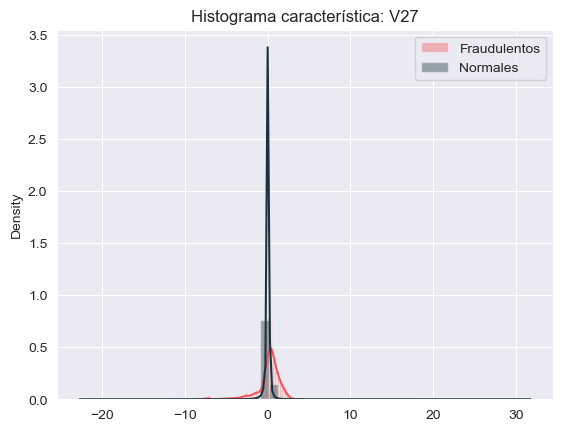

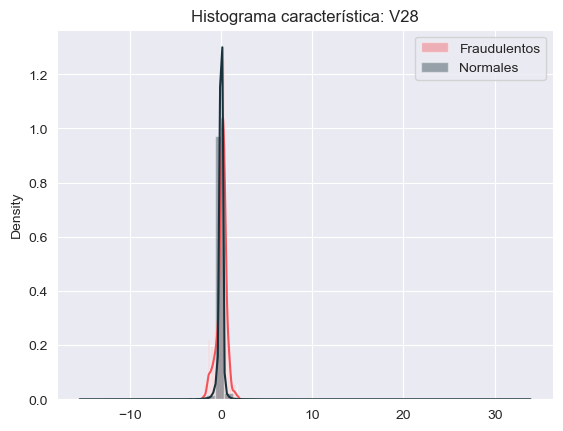

In [8]:
# Distribución de las características V1 a V28 en normales y fraudulentos
import matplotlib.gridspec as gridspec
import seaborn as sns

v_1_28 = datos.iloc[:,1:29].columns
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datos[v_1_28]):
    sns.distplot(datos[cn][datos.Class == 1], bins=50, 
    	label='Fraudulentos', color='#F2545B')
    sns.distplot(datos[cn][datos.Class == 0], bins=50, 
    	label='Normales', color='#19323C')
    plt.xlabel('')
    plt.title('Histograma característica: ' + str(cn))
    plt.legend(loc='upper right')
    plt.show()

In [9]:
# 3. PRE-PROCESAMIENTO
# ===============================================

# 3.1 La variable "Tiempo" no aporta información. La eliminaremos
from sklearn.preprocessing import StandardScaler
datos.drop(['Time'], axis=1, inplace=True)
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(datos, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

In [12]:
# 4. AUTOENCODER: 29-20-14-20-29, tanh-relu-tanh-relu
# ===================================================
import numpy as np
np.random.seed(5)
from keras.models import Model, load_model
from keras.layers import Input, Dense

dim_entrada = X_train.shape[1]          # 29
capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(20, activation='tanh')(capa_entrada)
encoder = Dense(14, activation='relu')(encoder)

decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(29, activation='relu')(decoder)

autoencoder = Model(inputs=capa_entrada, outputs=decoder)

from keras.optimizers import SGD
sgd = SGD(learning_rate=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

nits = 100
tam_lote = 32
autoencoder.fit(X_train, X_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(X_test,X_test), verbose=1)


Epoch 1/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.9574 - val_loss: 0.8521
Epoch 2/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7952 - val_loss: 0.8027
Epoch 3/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7644 - val_loss: 0.7796
Epoch 4/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7483 - val_loss: 0.7615
Epoch 5/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7199 - val_loss: 0.7454
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.6976 - val_loss: 0.7328
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6906 - val_loss: 0.7237
Epoch 8/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6975 - val_loss: 0.7169
Epoch 9/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6972 - val_loss: 0.7113
Epoch 10/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6672 - val_loss: 0.7067
Epoch 11/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.6751 - val_loss: 0.7031
Epoch 12/100
7

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step
(56962, 29)


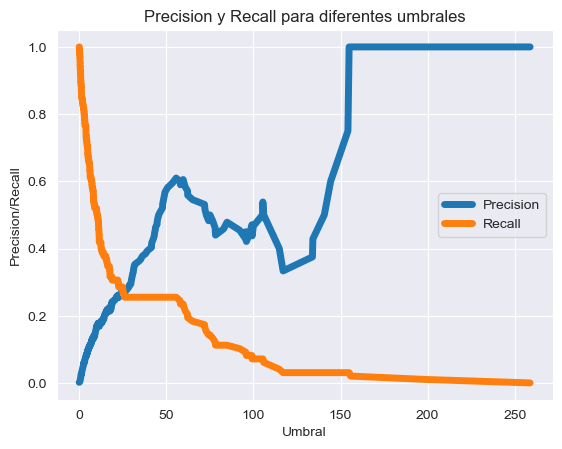

In [13]:
# 5. VALIDACIÓN
# ===============================================

# Predicción X_test -> Autoencoder -> X_pred
X_pred = autoencoder.predict(X_test)
ecm = np.mean(np.power(X_test-X_pred,2), axis=1)
print(X_pred.shape)

# Gráfica precision-recall para determinar el umbral
from sklearn.metrics import confusion_matrix, precision_recall_curve
precision, recall, umbral = precision_recall_curve(Y_test, ecm)

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [14]:
# 5.3. Matriz de confusión
umbral_fijo = 0.75
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(conf_matrix)

[[49522  7342]
 [    7    91]]
